# Projet de DSSS

- [Formation de la base de données](#formation)
  - [Importation et nettoyage de le base principale](#principale)
    - [Importations des données](#Importations)
    - [Ajout de l'altitude des points](#altitude)
    - [Recherche du point de la rivière précédent](#precedent)
  - [Densité de population](#densite)
  - [Ouvrage de dépollution](#ouvrage)
  - [Industries polluantes](#pollution)
  - [Débit des rivières](#debit)
    - [Première tentative avec usage de l'API](#api)
    - [Imputation des données manquantes en ReGex](#simil)
    - [Imputation avec usage moins strict de l'API](#api2)
  - [Trafic moyen journalier](#trafic)
    - [Calcul et imputation du TMJA](#tmja)
    - [Visualisations](#visualisations)
  - [Surfaces agricoles](#agri)  
    - [Identification des surfaces agricoles bio](#bio)
    - [Proportion de surface agricole](#prop)
- [Analyses économétriques et statistiques](#analyse)
  - [Régréssion linéaire simple](#simple)
  - [Indicateur factoriel](#indicateur)
  - [Régréssion hiérarchique](#multi)
  - [Modèle standardisé](#stand)
  - [Arbre de décision et random forest](#tree)
- [Visualisation des analyses](#visu)
  - [Visualisation des arbres](#treeviz)
  - [Visualisation des coefficients](#coeff)


<h2 id="formation">Formation de la base de données</h2>


<h3 id="principale">Importation et nettoyage de le base principale</h3>


<h4 id="importations">Importations des données</h4>


In [ ]:
from scipy.spatial import cKDTree
import numpy as np
from tqdm import tqdm  
import time
import pandas as pd
from time import sleep
import requests

stations = pd.read_csv("C:/Users/arman/OneDrive/Bureau/Projet_DSSS/Data/Qualite/Qualite_riv_2023/stations.csv", sep = ";")
etat_station = pd.read_csv("C:/Users/arman/OneDrive/Bureau/Projet_DSSS/Data/Qualite/Qualite_riv_2023/etat_station.csv", sep = ";")

In [ ]:

etat_station = pd.merge(stations, etat_station, on="CODSTA")

columns_to_keep = ['CODSTA', 'NOMSTA_x', 'CODE_MASSEDEAU', 'LON_WGS84', 'LAT_WGS84',
                   'ETAT_VISU', 'NOMSTA_y', 'ANNEE', 'OBJET_EVAL', 'ETATPOT_ECO']

etat_station = etat_station[columns_to_keep]

etat_station['ETATPOT_ECO'] = pd.to_numeric(etat_station['ETATPOT_ECO'], errors='coerce')

# Groupe par 'CODSTA' et calcul de la moyenne de 'ETATPOT_ECO', tout en conservant les autres colonnes pertinentes
etat_station = etat_station.groupby('CODSTA').agg({
    'NOMSTA_x': 'first',  # Garde la première occurrence
    'CODE_MASSEDEAU': 'first',  # Idem
    'LON_WGS84': 'first',  # Idem
    'LAT_WGS84': 'first',  # Idem
    'ETAT_VISU': 'first',  # Idem
    'NOMSTA_y': 'first',  # Idem
    'ANNEE': 'min',  
    'OBJET_EVAL': 'first',  # Idem
    'ETATPOT_ECO': 'mean'  # Calcule la moyenne de 'ETATPOT_ECO'
}).reset_index()



columns_to_keep = ['CODSTA', 'NOMSTA_x', 'CODE_MASSEDEAU', 'LON_WGS84', 'LAT_WGS84', 'NOMSTA_y', 'ETATPOT_ECO']
etat_station = etat_station[columns_to_keep]



In [ ]:
import matplotlib.pyplot as plt

# Création de l'histogramme
plt.hist(round(etat_station['ETATPOT_ECO']), bins=5, color='blue', edgecolor='black')

# Ajout de titres et labels
plt.title('Distribution de ETATPOT_ECO')
plt.xlabel('ETATPOT_ECO')
plt.ylabel('Fréquence')

# Affichage du graphique
plt.show()


<h4 id="altitude">Ajout de l'altitude des points</h4>


In [2]:
import requests
def get_elevation(lat, lon):
    api_url = f"https://api.open-elevation.com/api/v1/lookup?locations={lat},{lon}"
    response = requests.get(api_url)
    if response.ok:
        # L'API Open Elevation retourne une liste d'objets pour 'results'
        results = response.json().get('results', [])
        if results:
            # Supposons que nous prenons le premier résultat dans la liste
            return results[0].get('elevation', None)
        else:
            return None
    else:
        # Gérer les réponses non réussies ici
        return None

def compare_elevation(coord1, coord2):
    elevation1 = get_elevation(*coord1)
    elevation2 = get_elevation(*coord2)

    if elevation1 is None or elevation2 is None:
        return "L'altitude d'un ou des deux points n'a pas pu être déterminée."

    if elevation1 > elevation2:
        return "Le premier point est à une altitude plus élevée."
    elif elevation1 < elevation2:
        return "Le second point est à une altitude plus élevée."
    else:
        return "Les deux points sont à la même altitude."

# Exemple d'utilisation de la fonction
coord_point1 = (48.8566, 2.3522)  # Coordonnées de Paris
coord_point2 = (45.7640, 4.8357)  # Coordonnées de Lyon

result = compare_elevation(coord_point1, coord_point2)


In [ ]:

max_attempts = 5  # Nombre maximum de tentatives pour obtenir une altitude valide

for index, row in tqdm(etat_station.iterrows(), total=etat_station.shape[0]):
    lat, lon = row['LAT_WGS84'], row['LON_WGS84']
    attempts = 0
    altitude = None

    while altitude is None and attempts < max_attempts:
        altitude = get_elevation(lat, lon)
        attempts += 1
        if altitude is None:
            time.sleep(1)  # Pause pour éviter de surcharger l'API

    etat_station.at[index, 'altitude'] = altitude


<h4 id="precedent">Recherche du point de la rivière précédent</h4>


In [ ]:

# Trier le DataFrame par 'CODE_MASSEDEAU' et 'altitude' en ordre croissant
etat_station.sort_values(by=['CODE_MASSEDEAU', 'altitude'], inplace=True)
# Initialiser la nouvelle colonne avec des 1 : si il n'y a pas de points précédents alors on considère que la riviere est saine
etat_station['Etat_precedent'] = 1

# Pour chaque station, chercher le premier point en amont (c'est-à-dire avec une altitude supérieure)
for i in tqdm(range(len(etat_station) - 2, -1, -1), desc='Calcul de l\'Etat précédent'):
    current_row = etat_station.iloc[i]
    for j in range(i + 1, len(etat_station)):
        next_row = etat_station.iloc[j]

        if current_row['CODE_MASSEDEAU'] == next_row['CODE_MASSEDEAU'] and next_row['altitude'] > current_row['altitude']:
            etat_station.at[etat_station.index[i], 'Etat_precedent'] = next_row['ETATPOT_ECO']
            break  # Arrêter la recherche dès qu'un point en amont est trouvé


 <h3 id="densite">Densité de population</h3>

In [ ]:
from scipy.spatial import cKDTree
import numpy as np
from tqdm import tqdm  
import time
import pandas as pd
from time import sleep
import requests

demography = pd.read_excel("C:/Users/arman/OneDrive/Bureau/Projet_DSSS/Data/Controle/densite_pop.xlsx", sheet_name="Data")

demography = demography.iloc[3:]
demography.columns = demography.iloc[0]
demography = demography.iloc[1:]
demography.reset_index(drop=True, inplace=True)
demography['an'] = pd.to_numeric(demography['an'], errors='coerce')
demography = demography.loc[demography['an'] == 2020]
columns_to_keep = ['codgeo', 'dens_pop']
demography = demography[columns_to_keep]

In [ ]:


etat_station['codgeo'] = None

# Fonction pour obtenir le code INSEE (ou code_geo) basé sur la latitude et la longitude
def get_insee_code(lat, lon):
    url = f"https://api-adresse.data.gouv.fr/reverse/?lon={lon}&lat={lat}"
    for attempt in range(3):  # Réessayer jusqu'à 3 fois
        try:
            response = requests.get(url)
            response.raise_for_status()  # Cela lève une exception si la requête a échoué
            data = response.json()
            features = data.get('features')
            if features:
                properties = features[0].get('properties')
                insee_code = properties.get('citycode')
                return insee_code
            else:
                sleep(1)  # Attendre un peu avant de réessayer
        except requests.RequestException as e:
            print(f"Request failed: {e}, attempt {attempt+1}")
            sleep(1)  # Attendre un peu avant de réessayer
    return None  # Retourner None après 3 tentatives échouées


In [ ]:
# Identification des lignes où 'code_geo' est manquant
missing_code_geo_indices = etat_station[etat_station['codgeo'].isna()].index

# Itération sur les lignes avec 'codgeo' manquant pour essayer de récupérer le code INSEE
for index in tqdm(missing_code_geo_indices, total=len(missing_code_geo_indices), desc="Mise à jour de codgeo"):
    row = etat_station.loc[index]
    lat, lon = row['LAT_WGS84'], row['LON_WGS84']
    code_geo = get_insee_code(lat, lon)

    # Mise à jour du 'codgeo' seulement si un code valide est récupéré
    if code_geo:
        etat_station.at[index, 'codgeo'] = code_geo

In [ ]:
etat_station = pd.merge(etat_station, demography, on="codgeo", how='left')
etat_station.sample(2)

 <h3 id="ouvrage">Ouvrage de dépollution</h3>

In [6]:
from scipy.spatial import cKDTree
import numpy as np
from tqdm import tqdm  
import time
import pandas as pd
from scipy.spatial import distance
from scipy.spatial import cKDTree
from shapely.geometry import Point
import geopandas as gpd
from pyproj import Transformer

ouvrage = pd.read_csv("/home/onyxia/work/ouvrage_de_depollution.csv", sep =";")
ouvrage = ouvrage.iloc[1:]
ouvrage = ouvrage.loc[ouvrage['ProjCoordOuvrageDepollution'] == "26"]
ouvrage['altitude'] = None

**Conversion des coordonnées**

In [7]:

# Création d'un transformateur qui convertit de Lambert 93 en WGS84
transformer = Transformer.from_crs('epsg:2154', 'epsg:4326', always_xy=True)

# Fonction pour convertir une ligne du DataFrame
def convert_coords(row):
    x, y = row['CoordXOuvrageDepollution'], row['CoordYOuvrageDepollution']
    lon, lat = transformer.transform(x, y)
    return lon, lat

# Appliquer la conversion à chaque ligne
ouvrage['Longitude'], ouvrage['Latitude'] = zip(*ouvrage.apply(convert_coords, axis=1))
col_to_keep = ["Longitude", "Latitude",'CapaciteNom']
ouvrage = ouvrage[col_to_keep]


**Ajout de l'altitude**

In [14]:
ouvrage['altitude'] = None
# On filtre d'abord pour obtenir uniquement les indices des lignes où 'altitude' est NA
indices_na = ouvrage[ouvrage['altitude'].isna()].index

# On itère uniquement sur ces lignes
for index in tqdm(indices_na, total=len(indices_na)):
    row = ouvrage.loc[index]
    lat, lon = row['Latitude'], row['Longitude']
    attempts = 0
    altitude = None

    while altitude is None and attempts < 5:
        altitude = get_elevation(lat, lon)
        attempts += 1
        if altitude is None:
            time.sleep(1)  # Pause pour éviter de surcharger l'API

    # On met à jour l'altitude seulement si on a obtenu une valeur non-NA
    if altitude is not None:
        ouvrage.at[index, 'altitude'] = altitude

100%|██████████| 22274/22274 [2:35:59<00:00,  2.38it/s]   


In [15]:
ouvrage = ouvrage.dropna()

In [16]:
ouvrage.to_csv('/home/onyxia/work/ouvrage_alti.csv', sep =";", index=False)


**Recherche de la station de dépollution**

Conversion en geodataframe

In [17]:


# Conversion des DataFrame en GeoDataFrame
gdf_etat_station = gpd.GeoDataFrame(
    etat_station,
    geometry=gpd.points_from_xy(etat_station.LON_WGS84, etat_station.LAT_WGS84),
    crs="EPSG:4326"
)
gdf_etat_station = gdf_etat_station.to_crs(epsg=32633)  # Conversion en UTM pour calculer des distances en mètres

gdf_ouvrage = gpd.GeoDataFrame(
    ouvrage,
    geometry=gpd.points_from_xy(ouvrage.Longitude, ouvrage.Latitude),
    crs="EPSG:4326"
)
gdf_ouvrage = gdf_ouvrage.to_crs(epsg=32633)  # Même conversion pour avoir des unités cohérentes


Calcul de la distance avec le point précédent 

In [19]:
# Trier le GeoDataFrame par 'CODE_MASSEDEAU' et 'altitude' en ordre croissant
gdf_etat_station.sort_values(by=['CODE_MASSEDEAU', 'altitude'], inplace=True)

gdf_etat_station['Prev_Geometry'] = gdf_etat_station.groupby('CODE_MASSEDEAU')['geometry'].shift(1)

# Calculer la distance entre chaque point et son point décalé
gdf_etat_station['Distance_Prec'] = gdf_etat_station.apply(
    lambda row: row['geometry'].distance(row['Prev_Geometry']) if pd.notnull(row['Prev_Geometry']) else np.nan, axis=1
)

# Remplacer les NaN par 15 km pour les premiers points de chaque groupe
gdf_etat_station['Distance_Prec'] = gdf_etat_station['Distance_Prec'].fillna(10000)

# Nettoyer: supprimer la colonne temporaire
gdf_etat_station.drop(columns=['Prev_Geometry'], inplace=True)

Recherche de la station spécifique à chaque point

In [20]:
# Convertir les coordonnées des ouvrages pour utilisation avec cKDTree
ouvrage_coords = np.array(list(zip(gdf_ouvrage.geometry.x, gdf_ouvrage.geometry.y)))

# Construction de l'arbre KD pour tous les ouvrages
tree = cKDTree(ouvrage_coords)

gdf_etat_station['Usine_Traitement'] = 0  # Initialiser la colonne à 0

for index, station in tqdm(gdf_etat_station.iterrows(), total=gdf_etat_station.shape[0], desc='Recherche usines de traitement'):
    # Déterminer la distance de recherche comme avant
    distance_recherche = station['Distance_Prec']
    
    # Trouver tous les ouvrages dans le rayon déterminé
    indices = tree.query_ball_point([station.geometry.x, station.geometry.y], r=distance_recherche)
    valid_indices = [idx for idx in indices if gdf_ouvrage.iloc[idx].geometry.y > station.geometry.y]  # En amont par altitude

    if valid_indices:
        # Si au moins un ouvrage valide est trouvé, marquer avec 1
        gdf_etat_station.at[index, 'Usine_Traitement'] = 1


Recherche usines de traitement: 100%|██████████| 12171/12171 [00:08<00:00, 1406.42it/s]


In [21]:
etat_station = pd.DataFrame(gdf_etat_station.drop(columns=['geometry']))

In [3]:

import pandas as pd

etat_station_diffus = pd.read_csv("/home/onyxia/work/df_pdss_V3 (1).csv", sep = ";")


In [4]:
columns_to_remove = etat_station_diffus.columns[etat_station_diffus.columns.get_loc('Nombre_ind'):etat_station_diffus.columns.get_loc('Zinc')+1]
etat_station_diffus.drop(columns=columns_to_remove, inplace=True)

etat_station_diffus.keys()


Index(['CODSTA', 'NOMSTA_x', 'CODE_MASSEDEAU', 'LON_WGS84', 'LAT_WGS84',
       'NOMSTA_y', 'ETATPOT_ECO', 'altitude', 'Etat_precedent', 'codgeo',
       'dens_pop', 'Distance_Prec', 'Usine_Traitement', 'débit', 'river',
       'TMJA_sum', 'total_agri_area', 'bio_agri_area'],
      dtype='object')

 <h3 id="pollution">Industries polluantes</h3>

In [5]:
import pandas as pd
from scipy.spatial import distance
import numpy as np
from pyproj import Transformer
from tqdm import tqdm 
import time

etablissement = pd.read_csv("/home/onyxia/work/etablissements.csv", sep = ";")
emissions = pd.read_csv("/home/onyxia/work/emissions.csv", sep = ";")

**Nettoyage des données**

In [6]:
emissions_pivot = emissions.pivot_table(index=['identifiant', 'nom_etablissement', 'annee_emission', 'milieu'],
                                        columns='polluant',
                                        values='quantite',
                                        aggfunc='sum').reset_index()

# Renommer les colonnes si nécessaire (pour supprimer le nom de niveau supérieur 'polluant')
emissions_pivot.columns.name = None  # Supprime le nom du MultiIndex sur les colonnes
emissions_pivot.columns = [str(col) for col in emissions_pivot.columns]  # Applatissement du MultiIndex en chaînes de caractères simples

emissions_pivot = emissions_pivot.dropna(axis=1, thresh=100)
emissions_pivot = emissions_pivot.dropna(subset=emissions_pivot.columns[4:], how='all')
rename_dict = {
    'Ammoniac (NH3)': 'NH3',
    'Azote total': 'Azote',
    'Composés organiques volatils non méthaniques (COVNM)': 'COVNM',
    'Cuivre et composés (exprimés en tant que Cu)': 'Cuivre',
    'Demande biologique en oxygène (DBO5)': 'DBO5',
    'Demande chimique en oxygène (DCO)': 'DCO',
    "Dioxyde de carbone (CO2) d'origine biomasse": 'CO2_Biomasse',
    "Dioxyde de carbone (CO2) d'origine non biomasse": 'CO2_Non_Biomasse',
    "Dioxyde de carbone (CO2) total (d'origine biomasse et non biomasse)": 'CO2_Total',
    'Hydroflurocarbures (HFC)': 'HFC',
    'Méthane (CH4)': 'CH4',
    'Nickel et composés (exprimés en tant que Ni)': 'Nickel',
    'Oxydes d\'azote (NOx/NO2)': 'NOx_NO2',
    'Phosphore total': 'Phosphore',
    'Plomb et composés (exprimés en tant que Pb)': 'Plomb',
    'Zinc et composés (exprimés en tant que Zn)': 'Zinc'
}

emissions_pivot.rename(columns=rename_dict, inplace=True) # Utilisez le dictionnaire pour renommer les colonnes



In [7]:
# Supposons que emissions_pivot est votre DataFrame d'origine

# Obtenir la liste des polluants à partir des noms de colonnes, en excluant les colonnes non polluantes
pollutant_columns = emissions_pivot.columns[4:]

# Créer un nouveau DataFrame pour stocker les résultats
emissions_with_milieu = emissions_pivot.copy()

# Pour chaque colonne de polluant, ajoutez le milieu à son nom
for milieu in emissions_pivot['milieu'].unique():
    for col in pollutant_columns:
        emissions_with_milieu[f'{col} ({milieu})'] = emissions_pivot.apply(
            lambda row: row[col] if row['milieu'] == milieu else None, axis=1
        )

# À ce stade, vous pouvez choisir de supprimer les anciennes colonnes de polluants si vous le souhaitez
emissions_with_milieu.drop(columns=pollutant_columns, inplace=True)
emissions_with_milieu.drop(columns='milieu', inplace=True)

emissions_with_milieu.dropna(axis=1, how='all', inplace=True)
# Tri des colonnes de polluants par ordre alphabétique
pollutant_columns_sorted = sorted([col for col in emissions_with_milieu.columns if '(' in col])

# Les colonnes qui ne sont pas des polluants restent en place
non_pollutant_columns = [col for col in emissions_with_milieu.columns if '(' not in col]

# Réorganiser le DataFrame avec les colonnes non polluantes suivies des polluants triés
emissions_with_milieu = emissions_with_milieu[non_pollutant_columns + pollutant_columns_sorted]





**Conversion des coordonnées et récupuération de l'altitude**

In [8]:

transformer = Transformer.from_crs('epsg:2154', 'epsg:4326', always_xy=True)

etablissement['code_epsg'] = pd.to_numeric(etablissement['code_epsg'], errors='coerce')
etablissement = etablissement.loc[etablissement['code_epsg'] == 2154.0]

def convert_coords2(row):
    x, y = row['coordonnees_x'], row['coordonnees_y']
    lon, lat = transformer.transform(x, y)
    return lon, lat

# Supposons que df est votre DataFrame contenant les données
# Appliquer la conversion à chaque ligne
etablissement['Longitude'], etablissement['Latitude'] = zip(*etablissement.apply(convert_coords2, axis=1))
col_to_keep = ['identifiant', "code_postal", "Longitude", "Latitude", "code_ape" ]
etablissement = etablissement[col_to_keep]

industrie_poll = pd.merge(emissions_with_milieu, etablissement, on = "identifiant", how = 'left')


In [9]:
na_count = industrie_poll['code_ape'].isna().sum()
print(f"Nombre de valeurs NA dans la colonne 'code_ape': {na_count}") #certains identifiants ne sont pas dans le dataframe etablissement

Nombre de valeurs NA dans la colonne 'code_ape': 602


In [10]:
max_attempts = 5  # Nombre maximum de tentatives pour obtenir une altitude valide

for index, row in tqdm(industrie_poll.iterrows(), total=industrie_poll.shape[0]):
    lat, lon = row['Latitude'], row['Longitude']
    attempts = 0
    altitude = None
    
    while altitude is None and attempts < max_attempts:
        altitude = get_elevation(lat, lon)
        attempts += 1
        if altitude is None:
            time.sleep(1)  # Pause pour éviter de surcharger l'API
        
    industrie_poll.at[index, 'altitude'] = altitude

100%|██████████| 2870/2870 [16:35<00:00,  2.88it/s]


**Calcul de la pollution émise par les industries proches des points de la rivière**

In [11]:

# Convertir les degrés en radians pour les calculs de distance
lat1 = np.radians(etat_station_diffus['LAT_WGS84'].values)
lon1 = np.radians(etat_station_diffus['LON_WGS84'].values)
lat2 = np.radians(industrie_poll['Latitude'].values)
lon2 = np.radians(industrie_poll['Longitude'].values)

# Calculer la matrice de distance entre chaque station et chaque industrie
earth_radius = 6371  # en kilomètres
dist_matrix = earth_radius * np.arccos(np.sin(lat1)[:, None] * np.sin(lat2)
                                       + np.cos(lat1)[:, None] * np.cos(lat2) * np.cos(lon1[:, None] - lon2))

# Trouver les industries à moins de 20 km pour chaque point de prélèvement
industries_within_20km = dist_matrix < 20

# Calculer le nombre d'industries polluantes dans le rayon de 20 km
etat_station_diffus['Nombre_ind'] = industries_within_20km.sum(axis=1)

# Calculer la somme de chaque polluant pour les industries à moins de 20 km
for pollutant in ['Azote (Eau (direct))', 'Azote (Eau (indirect))', 'Azote (Sol)',
       'CH4 (Air)', 'CO2_Biomasse (Air)', 'CO2_Non_Biomasse (Air)',
       'CO2_Total (Air)', 'COVNM (Air)', 'Cuivre (Air)',
       'Cuivre (Eau (direct))', 'Cuivre (Eau (indirect))', 'Cuivre (Sol)',
       'DBO5 (Eau (direct))', 'DBO5 (Eau (indirect))', 'DCO (Eau (direct))',
       'DCO (Eau (indirect))', 'HFC (Air)', 'NH3 (Air)', 'NOx_NO2 (Air)',
       'Nickel (Air)', 'Nickel (Eau (direct))', 'Nickel (Eau (indirect))',
       'Nickel (Sol)', 'Phosphore (Eau (direct))',
       'Phosphore (Eau (indirect))', 'Phosphore (Sol)', 'Plomb (Air)',
       'Plomb (Eau (direct))', 'Plomb (Eau (indirect))', 'Plomb (Sol)',
       'Zinc (Air)', 'Zinc (Eau (direct))', 'Zinc (Eau (indirect))',
       'Zinc (Sol)']:
    # On utilise np.dot pour effectuer la somme pondérée des polluants
    etat_station_diffus[pollutant] = np.dot(industries_within_20km, industrie_poll[pollutant].fillna(0).values)



<h3 id="debit">Débit des rivières</h3>


In [23]:
import pandas as pd
from geopy.geocoders import Nominatim
import numpy as np
from pyproj import Transformer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import requests
import matplotlib.pyplot as plt
from datetime import datetime

debit = pd.read_csv("/home/onyxia/work/q(moyen).csv")

In [24]:
# Filtrer pour garder seulement les données en France métropolitaine
debit = debit[(debit['Latitude'] >= 41) & (debit['Latitude'] <= 52) &
                     (debit['Longitude'] >= -5) & (debit['Longitude'] <= 10)]
col_to_keep = ['Libellé', 'Débit (l/s)']
debit = debit[col_to_keep]
debit = debit.dropna(subset=["Débit (l/s)"])
etat_station['débit'] = None

<h4 id="simil">Première imputation en ReGex</h4>

**Définition des fonctions pour extraire le nom de la rivière**


In [25]:
# Fonction pour extraire le nom de la rivière et la commune de 'debit'
def extract_river_and_commune_from_debit(libelle):
    match = re.search(r'(?i)(le\s+|la\s+|l\'|les\s+)(.+?)\s+(à\s+|au\s+|a\s+|en\s+|sur\s+|dans\s+)(.+)', libelle)
    if match:
        river = match.group(2).lower().strip()
        commune = match.group(4).lower().strip()
        return river, commune
    return None, None

# Fonction pour extraire le nom de la rivière de 'etat_station'
def extract_river_from_etat_station(libelle):
    # Supprimer les cas communs comme 'Le', 'La', 'L'' et 'Les'
    # et prendre en compte 'canal' ou 'ruisseau'
    match = re.search(r'(?i)(?:le\s+|la\s+|l\'|les\s+)?(?:canal\s+de\s+|ruisseau\s+de\s+|)(?:du\s+|de\s+la\s+|de\s+l\'|de\s+les\s+|de\s+)?([^\s]+(?:\s+[^\s]+)*)', libelle)
    if match:
        river = match.group(1).lower().strip()
        # Supprimer "l'" au début du nom de la rivière
        river = re.sub(r"^(l'|le |la |les )",'', river)
        # Supprimer les mots "le", "la", "les" s'ils sont présents à la fin du nom de la rivière
        river = re.sub(r'\s+(le|la|les)$', '', river)
        river = re.sub(r'\s+(à|au|a|en|sur|dans|par|de|du|des|rivière)\s+.*', '', river)
        return river
    return None

# Appliquer les fonctions de nettoyage aux deux dataframes
debit['river'], debit['commune'] = zip(*debit['Libellé'].apply(extract_river_and_commune_from_debit))
etat_station['river'] = etat_station['NOMSTA_x'].apply(extract_river_from_etat_station)

# Assurez-vous de nettoyer et de réinitialiser les index après avoir supprimé des lignes vides
debit.dropna(subset=['river'], inplace=True)
debit.reset_index(drop=True, inplace=True)

In [26]:
vectorizer = TfidfVectorizer()
tfidf_rivers_debit = vectorizer.fit_transform(debit['river'])
tfidf_rivers_etat_station = vectorizer.transform(etat_station['NOMSTA_x'])  # Assurez-vous que c'est le bon nom de colonne

# Calcul de la matrice de similarité
cosine_sim_matrix = cosine_similarity(tfidf_rivers_etat_station, tfidf_rivers_debit)

# Seuil de similarité
similarity_threshold = 0.8

# Parcourir chaque station et trouver la meilleure correspondance
for i, row_similarities in enumerate(cosine_sim_matrix):
    if pd.isna(etat_station.loc[i, 'débit']):
        if max(row_similarities) > similarity_threshold:     # Vérifier si la meilleure correspondance dépasse le seuil
            # Trouver l'indice de la meilleure correspondance
            best_match_idx = np.argmax(row_similarities)
            # Assigner le débit correspondant
            etat_station.at[i, 'débit'] = debit.loc[best_match_idx, 'Débit (l/s)']
        else:
            # Si pas de bonne correspondance, utiliser la moyenne des débits pour la même rivière
            river_name = etat_station.iloc[i]['river']  # Utilisation de la colonne 'river' extraite
            mean_debit = debit[debit['river'].str.contains(r'^' + re.escape(river_name) + r'$', regex=True, case=False, na=False)]['Débit (l/s)'].mean()

            # Si la rivière est trouvée dans `debit`, sinon NA
            etat_station.at[i, 'débit'] = mean_debit if not np.isnan(mean_debit) else np.nan

<h4 id="api">Seconde tentative avec un usage strict de l'API</h4>

Visualisation de la saisonalité

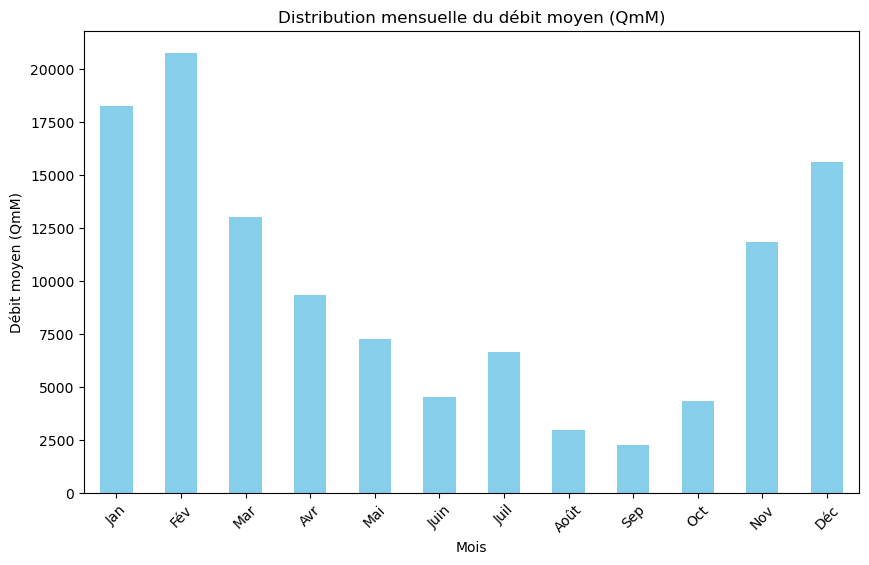

In [27]:

# Fonction pour collecter les données (simplifiée pour l'exemple)
def collect_data(lat, lon):
    base_url = "https://hubeau.eaufrance.fr/api/v1/hydrometrie/obs_elab"
    params = {
        'latitude': lat,
        'longitude': lon,
        'distance': 10,
        'date_debut_obs_elab': '2020-01-01',
        'grandeur_hydro_elab': 'QmM',
        'size': 10000,
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()['data']
        return data
    else:
        print(f"Erreur lors de la requête: {response.status_code}")
        return []

# Supposons que cette fonction renvoie une liste d'observations (simplifiée pour l'exemple)
data = collect_data(48.3263019080001, 6.90486534300004)

# Conversion des données en DataFrame
df = pd.DataFrame(data)

# Assurez-vous que les données contiennent 'resultat_obs_elab' et 'date_obs_elab'
if not df.empty and 'resultat_obs_elab' in df and 'date_obs_elab' in df:
    df['date_obs_elab'] = pd.to_datetime(df['date_obs_elab'])
    df['month'] = df['date_obs_elab'].dt.month
    monthly_debit = df.groupby('month')['resultat_obs_elab'].mean()

    # Affichage du graphique
    plt.figure(figsize=(10, 6))
    monthly_debit.plot(kind='bar', color='skyblue')
    plt.title('Distribution mensuelle du débit moyen (QmM)')
    plt.xlabel('Mois')
    plt.ylabel('Débit moyen (QmM)')
    plt.xticks(ticks=range(12), labels=['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'], rotation=45)
    plt.show()


In [28]:
import requests
from statistics import mean

def get_average_debit(lat, lon, distance):
    base_url = "https://hubeau.eaufrance.fr/api/v1/hydrometrie/obs_elab"
    debits = []
    page = 1
    max_retries = 5
    retry_delay = 5

    while True:
        try:
            params = {
                'latitude': lat,
                'longitude': lon,
                'distance': distance,  # Rayon de recherche de 10 km
                'date_debut_obs_elab': '2020-01-01',  # Depuis le début de 2020
                'grandeur_hydro_elab': 'QmM',  # Débit moyen mensuel
                'size': 10000,  # Nombre maximal d'observations par page
                'page': page
            }
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                data = response.json()
                observations = data.get('data', [])
                debits.extend([obs['resultat_obs_elab'] for obs in observations if obs.get('resultat_obs_elab') is not None])

                # Vérifier s'il y a une page suivante
                has_more_data = 'next' in data.get('links', {})
                if not has_more_data:
                    break  # Sortir de la boucle si toutes les pages ont été traitées
                page += 1
            else:
                raise ValueError(f"Erreur {response.status_code}: {response.text}")
        except ValueError as e:
            print(e)
            max_retries -= 1
            if max_retries == 0:
                print("Nombre maximal de tentatives atteint. Arrêt.")
                return None
            print(f"Tentative de récupération échouée. Nouvelle tentative dans {retry_delay} secondes.")
            time.sleep(retry_delay)

    if debits:
        return mean(debits)
    else:
        return None

In [29]:
missing_debit_rows = etat_station[pd.isna(etat_station['débit'])]

# Appliquer la fonction get_average_debit aux lignes filtrées avec tqdm
for i, row in tqdm(missing_debit_rows.iterrows(), total=missing_debit_rows.shape[0], desc="Mise à jour des débits manquants"):
    # Mettre à jour le DataFrame original, pas le sous-ensemble filtré
    etat_station.at[i, 'débit'] = get_average_debit(row['LAT_WGS84'], row['LON_WGS84'], 10)

Mise à jour des débits manquants: 100%|██████████| 7039/7039 [11:52<00:00,  9.88it/s]


In [30]:
missing_debit_rows = etat_station[pd.isna(etat_station['débit'])]
len(missing_debit_rows)

1579

<h4 id="api2">Imputation avec usage moins strict de l'API</h4> 

(optionnel, résultats pas fiables)

In [ ]:
""" 

missing_debit_rows = etat_station[pd.isna(etat_station['débit'])]

# Appliquer la fonction get_average_debit aux lignes filtrées avec tqdm
for i, row in tqdm(missing_debit_rows.iterrows(), total=missing_debit_rows.shape[0], desc="Mise à jour des débits manquants"):
    # Mettre à jour le DataFrame original, pas le sous-ensemble filtré
    etat_station.at[i, 'débit'] = get_average_debit(row['LAT_WGS84'], row['LON_WGS84'], 15) 
    """

<h3 id="trafic">Trafic moyen journalier</h3>


In [31]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
routes = gpd.read_file("/home/onyxia/work/TMJA2017_SHP.shp")
#etat_station = pd.read_csv("/home/onyxia/work/ES_debit.csv", sep = ";")

<h4 id="tmja">Calcul et imputation du TMJA</h4>


In [32]:
gdf_points = gpd.GeoDataFrame(
    etat_station,
    geometry=[Point(xy) for xy in zip(etat_station['LON_WGS84'], etat_station['LAT_WGS84'])],
    crs="EPSG:4326"  # WGS 84
)
gdf_points = gdf_points.to_crs("EPSG:2154")
gdf_points['buffer'] = gdf_points.geometry.buffer(2000)  # 2 km

gdf_buffers = gdf_points[['buffer']].copy()
gdf_buffers = gdf_buffers.set_geometry('buffer')

# Effectuer un spatial join entre les buffers et les routes
joined = gpd.sjoin(gdf_buffers, routes, how="inner", predicate="intersects")

# Calculer la somme de TMJA pour chaque buffer
tmja_sums = joined.groupby(joined.index)['tmja'].sum()

gdf_points['TMJA_sum'] = gdf_points.index.map(tmja_sums).fillna(0)


In [33]:
etat_station = pd.DataFrame(gdf_points.drop(columns=['geometry', 'buffer']))

<h4 id="visualisations">Visualisations</h4>

In [34]:
zero_frequency = (etat_station['TMJA_sum'] == 0).mean()
zero_frequency

0.8431517541697477

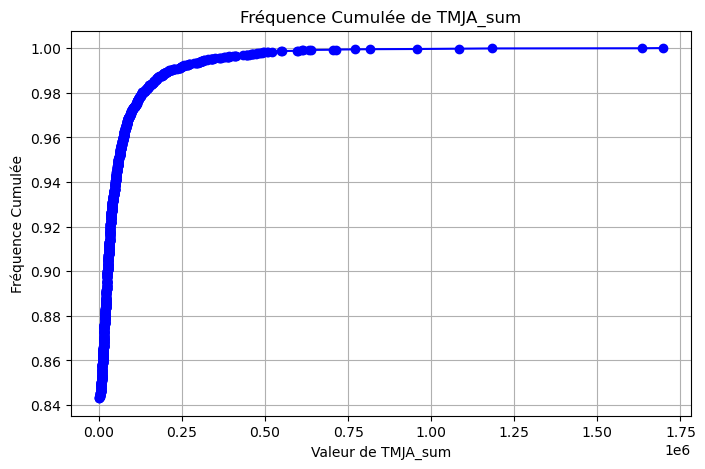

In [35]:
# Calculer les valeurs et les comptes
values, counts = np.unique(etat_station['TMJA_sum'], return_counts=True)

# Calculer les fréquences cumulées
cumulative_frequency = np.cumsum(counts) / etat_station.shape[0]

# Tracer la fréquence cumulée
plt.figure(figsize=(8, 5))
plt.plot(values, cumulative_frequency, marker='o', linestyle='-', color='b')
plt.title('Fréquence Cumulée de TMJA_sum')
plt.xlabel('Valeur de TMJA_sum')
plt.ylabel('Fréquence Cumulée')
plt.grid(True)

# Afficher le graphique
plt.show()


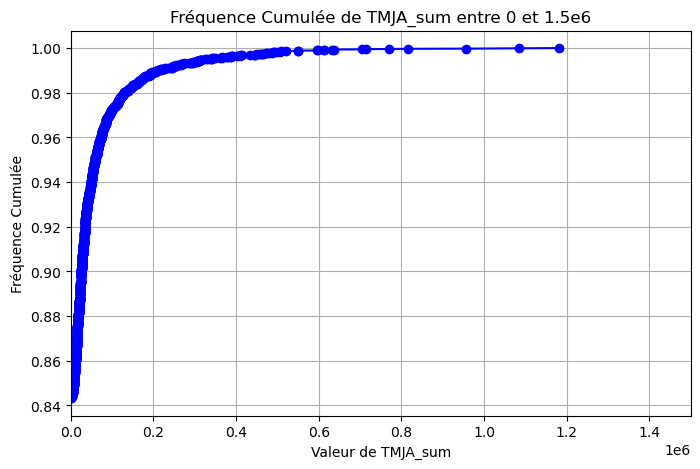

In [36]:
# Filtrer les données pour l'intervalle [0, 1.5 * 10^6]
filtered_values = etat_station[etat_station['TMJA_sum'].between(0, 1.5e6)]['TMJA_sum']

# Calculer les valeurs et les comptes pour l'intervalle filtré
values, counts = np.unique(filtered_values, return_counts=True)

# Calculer les fréquences cumulées
cumulative_frequency = np.cumsum(counts) / filtered_values.shape[0]

# Tracer la fréquence cumulée pour l'intervalle filtré
plt.figure(figsize=(8, 5))
plt.plot(values, cumulative_frequency, marker='o', linestyle='-', color='b')
plt.title('Fréquence Cumulée de TMJA_sum entre 0 et 1.5e6')
plt.xlabel('Valeur de TMJA_sum')
plt.ylabel('Fréquence Cumulée')
plt.grid(True)

# Définir les limites de l'axe x pour le zoom souhaité
plt.xlim(0, 1.5e6)

# Afficher le graphique
plt.show()


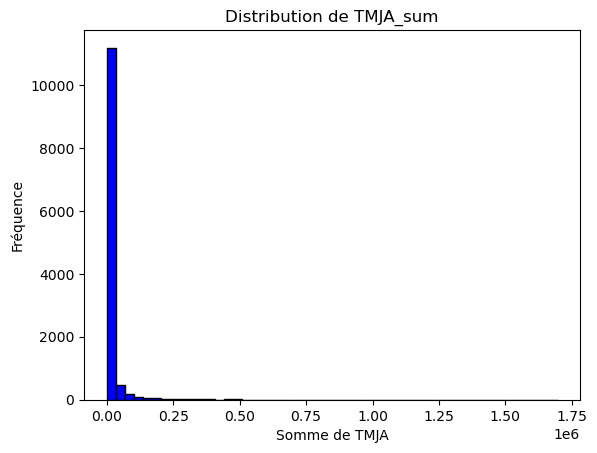

In [37]:
# Création de l'histogramme
plt.hist(gdf_points['TMJA_sum'], bins=50, color='blue', edgecolor='black')

# Ajout de titres et labels
plt.title('Distribution de TMJA_sum')
plt.xlabel('Somme de TMJA')
plt.ylabel('Fréquence')

# Affichage du graphique
plt.show()

<h3 id="agri">Surfaces agricoles</h3>


<h4 id="bio">Identification des surfaces agricoles bio</h4>


In [40]:
import pandas as pd
from geopandas import GeoDataFrame
from shapely.wkb import loads
import binascii
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
from tqdm import tqdm
import pygeos
import numpy as np
from shapely.geometry import Point
import math


#rpg_bio = pd.read_csv("/home/onyxia/work/test_rpg_bio.csv", sep =";")
rpg = pd.read_csv("/home/onyxia/work/test_rpg.csv", sep =";")
rpg_bio22 = ad_file("/home/onyxia/work/rpg-bio-2022-national.shp", encoding= "UTF-8" )gpd.re

In [41]:
#rpg_bio['geometry'] = rpg_bio['wkb_geometry'].apply(lambda x: loads(binascii.unhexlify(x)))
rpg['geometry'] = rpg['the_geom'].apply(lambda x: loads(binascii.unhexlify(x)))

#gdf_rpg_bio = GeoDataFrame(rpg_bio, geometry='geometry')
gdf_rpg = GeoDataFrame(rpg, geometry='geometry')
#gdf_rpg_bio.crs = "EPSG:2154"  # Définir le CRS actuel correctement si nécessaire
#gdf_rpg_bio = gdf_rpg_bio.to_crs("EPSG:4326")  # Reprojeter vers EPSG:4326
gdf_rpg.crs = "EPSG:2154"  # Définir le CRS actuel correctement si nécessaire
gdf_rpg = gdf_rpg.to_crs("EPSG:4326")  # Reprojeter vers EPSG:4326


In [42]:

# Définissez un polygone approximatif de la France métropolitaine.
france_metropolitaine_polygone_large = Polygon([
    (-5.5, 51.0),  # Étendu vers le nord-ouest
    (9.5, 51.0),   # Étendu vers le nord-est
    (9.5, 41.0),   # Étendu vers le sud-est
    (-5.5, 41.0)   # Étendu vers le sud-ouest
])


gdf_rpg = gdf_rpg[gdf_rpg.intersects(france_metropolitaine_polygone_large)]

In [43]:
# Fonction pour créer un convex hull à partir d'un MultiPolygon
def to_convex_hull(multipolygon):
    if isinstance(multipolygon, (MultiPolygon, Polygon)):
        return multipolygon.convex_hull
    else:
        raise ValueError("La géométrie n'est ni un Polygon ni un MultiPolygon")

gdf_rpg['geometry'] = gdf_rpg['geometry'].apply(to_convex_hull)
#gdf_rpg_bio['geometry'] = gdf_rpg_bio['geometry'].apply(to_convex_hull)

tqdm.pandas(desc="Conversion en PyGEOS")

# Conversion des GeoDataFrames en géométries PyGEOS pour une manipulation plus rapide
gdf_rpg['geom_pygeos'] = gdf_rpg['geometry'].progress_apply(pygeos.from_shapely)
rpg_bio22['geom_pygeos'] = rpg_bio22['geometry'].progress_apply(pygeos.from_shapely)

Conversion en PyGEOS:   0%|          | 0/9892474 [00:00<?, ?it/s]/opt/mamba/lib/python3.11/site-packages/pygeos/io.py:89: UserWarning: The shapely GEOS version (3.12.1-CAPI-1.18.1) is incompatible with the PyGEOS GEOS version (3.10.4-CAPI-1.16.2). Conversions between both will be slow
  warnings.warn(
Conversion en PyGEOS: 100%|██████████| 1085957/1085957 [00:25<00:00, 42421.30it/s]


In [44]:
gdf_rpg.reset_index(drop=True, inplace=True)
rpg_bio22.reset_index(drop=True, inplace=True)
# Création d'un index spatial PyGEOS pour gdf_rpg
tree = pygeos.STRtree(gdf_rpg['geom_pygeos'])

# Utilisation de tqdm pour suivre la progression de la recherche du plus proche voisin
nearest_neighbor_idxs = []
for geom in tqdm(rpg_bio22['geom_pygeos'], desc="Recherche du plus proche voisin"):
    # Utilisation de la méthode "nearest" pour obtenir l'indice du voisin le plus proche
    nearest_idx = tree.nearest(geom)[1][0]
    nearest_neighbor_idxs.append(nearest_idx)

rpg_bio22['nearest_idx'] = nearest_neighbor_idxs
# Fusion des informations bio et non-bio basée sur l'index du plus proche voisin
# Attribuez 1 à toutes les exploitations dans gdf_rpg_bio (bio)
rpg_bio22['is_bio'] = 1

temp_bio = rpg_bio22[['nearest_idx']].drop_duplicates()
temp_bio['is_bio'] = 1

# Fusionner cette DataFrame temporaire avec gdf_rpg basé sur 'index_rpg' et 'nearest_idx'
gdf_final = gdf_rpg.merge(temp_bio, left_index = True, right_on='nearest_idx', how='left')
gdf_final['is_bio'] = gdf_final['is_bio'].fillna(0)


Recherche du plus proche voisin: 100%|██████████| 1085957/1085957 [02:40<00:00, 6748.54it/s] 


<h4 id="prop">Proportion de surface agricole</h4>

In [45]:
# Conversion de etat_station en GeoDataFrame
gdf_points = gpd.GeoDataFrame(
    etat_station,
    geometry=[Point(xy) for xy in zip(etat_station['LON_WGS84'], etat_station['LAT_WGS84'])],
    crs="EPSG:4326"  # WGS 84
)
gdf_points = gdf_points.to_crs("EPSG:2154")
# Reprojection en Lambert-93
gdf_points = gdf_points.to_crs("EPSG:2154")
gdf_final = gdf_final.to_crs("EPSG:2154")

# Calcul des buffers de 5 km
buffer_radius = 5000  # 5 km en mètres
gdf_points['buffer'] = gdf_points.geometry.buffer(buffer_radius)


In [46]:
# Configuration de tqdm pour pandas
tqdm.pandas(desc="Calculating areas")

# Fonction pour calculer les surfaces totales et bio dans les buffers
def calculate_area(row, gdf_final):
    # Sélection des exploitations dans le buffer
    in_buffer = gdf_final[gdf_final.intersects(row['buffer'])]
    
    # Calcul des surfaces
    total_area = in_buffer.geometry.area.sum()
    bio_area = in_buffer[in_buffer['is_bio'] == 1].geometry.area.sum()
    
    # Retourner les surfaces totales et bio
    return pd.Series([total_area, bio_area])

# Appliquer la fonction à chaque point avec progression
results = gdf_points.progress_apply(lambda row: calculate_area(row, gdf_final), axis=1)

# Assigner les résultats au GeoDataFrame
gdf_points[['total_agri_area', 'bio_agri_area']] = results

# Normaliser par la surface du buffer pour obtenir des proportions
circle_area = math.pi * buffer_radius ** 2
gdf_points['total_agri_area'] /= circle_area
gdf_points['bio_agri_area'] /= circle_area

Calculating areas: 100%|██████████| 12171/12171 [2:04:09<00:00,  1.63it/s] 


In [47]:
gdf_points['total_agri_area'] = gdf_points['total_agri_area'].clip(upper=1)

In [48]:
df_pdss = pd.DataFrame(gdf_points.drop(columns=['geometry', 'buffer']))

In [49]:
#df_pdss.to_csv('/home/onyxia/work/df_pdss_V3.csv', sep= ";", index=False)

<h2 id="analyse">Analyses économétriques</h1>


In [1]:
import pandas as pd
df_pdss = pd.read_csv("/home/onyxia/work/df_pdss_diffus (1).csv", sep = ";")

In [2]:
# Liste des colonnes pour lesquelles compter le nombre de NaN
cols_with_nan = ['CODE_MASSEDEAU', 'ETATPOT_ECO', 'altitude', 'Etat_precedent', 'codgeo', 'dens_pop', 'débit']
df_pdss['Etat_precedent'] = df_pdss['Etat_precedent'].fillna(1)

# Compter le nombre de NaN pour chaque colonne spécifiée
nan_counts = df_pdss[cols_with_nan].isnull().sum()

# Supprimer les lignes où il y a des NaN dans 'ETATPOT_ECO' ou 'dens_pop'
df_filtered = df_pdss.dropna(subset=['ETATPOT_ECO', 'débit', "dens_pop"])

# Vérification rapide du résultat
print(f"Nombre de lignes avant suppression : {df_pdss.shape[0]}")
print(f"Nombre de lignes après suppression : {df_filtered.shape[0]}")


Nombre de lignes avant suppression : 12171
Nombre de lignes après suppression : 7734


<h3 id="simple">Régréssion linéaire simple</h3>


In [3]:
import statsmodels.api as sm

#for column in df_filtered.select_dtypes(include=['object']).columns:
  #  df_filtered[column] = pd.to_numeric(df_filtered[column], errors='coerce')


Y_simple = df_filtered['ETATPOT_ECO']
X_simple = df_filtered[['Etat_precedent', 'dens_pop', 'débit', 'Nombre_ind', 'Usine_Traitement',
       'Azote (Eau (direct))', 'Azote (Eau (indirect))', 'Azote (Sol)',
       'CH4 (Air)', 'CO2_Biomasse (Air)', 'CO2_Non_Biomasse (Air)',
       'CO2_Total (Air)', 'COVNM (Air)', 'Cuivre (Air)',
       'Cuivre (Eau (direct))', 'Cuivre (Eau (indirect))', 'Cuivre (Sol)',
       'DBO5 (Eau (direct))', 'DBO5 (Eau (indirect))', 'DCO (Eau (direct))',
       'DCO (Eau (indirect))', 'HFC (Air)', 'NH3 (Air)', 'NOx_NO2 (Air)',
       'Nickel (Air)', 'Nickel (Eau (direct))', 'Nickel (Eau (indirect))',
       'Nickel (Sol)', 'Phosphore (Eau (direct))',
       'Phosphore (Eau (indirect))', 'Phosphore (Sol)', 'Plomb (Air)',
       'Plomb (Eau (direct))', 'Plomb (Eau (indirect))', 'Plomb (Sol)',
       'Zinc (Air)', 'Zinc (Eau (direct))', 'Zinc (Eau (indirect))',
       'Zinc (Sol)', 'total_agri_area', 'bio_agri_area', 'TMJA_sum']]

# Ajouter une constante à X pour intercepter
X_simple = sm.add_constant(X_simple)

# Construire le modèle
model_simple = sm.OLS(Y_simple, X_simple).fit()
#model_simple = sm.OLS(Y_simple, X_simple).fit(cov_type='HC3')

# Afficher le résumé du modèle
print(model_simple.summary())


                            OLS Regression Results                            
Dep. Variable:            ETATPOT_ECO   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     16.21
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          8.90e-111
Time:                        15:02:56   Log-Likelihood:                -9795.9
No. Observations:                7734   AIC:                         1.968e+04
Df Residuals:                    7691   BIC:                         1.998e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

<h3 id="indicateur">Indicateur factoriel</h3>


In [4]:
import pandas as pd
import numpy as np

# Définition des colonnes de polluants
pollutant_cols = ['Azote (Eau (direct))', 'Azote (Eau (indirect))', 'Azote (Sol)',
       'CH4 (Air)', 'COVNM (Air)', 'Cuivre (Air)',
       'Cuivre (Eau (direct))', 'Cuivre (Eau (indirect))', 'Cuivre (Sol)',
       'DBO5 (Eau (direct))', 'DBO5 (Eau (indirect))', 'DCO (Eau (direct))',
       'DCO (Eau (indirect))', 'HFC (Air)', 'NH3 (Air)', 'NOx_NO2 (Air)',
       'Nickel (Air)', 'Nickel (Eau (direct))', 'Nickel (Eau (indirect))',
       'Nickel (Sol)', 'Phosphore (Eau (direct))',
       'Phosphore (Eau (indirect))', 'Phosphore (Sol)', 'Plomb (Air)',
       'Plomb (Eau (direct))', 'Plomb (Eau (indirect))', 'Plomb (Sol)',
       'Zinc (Air)', 'Zinc (Eau (direct))', 'Zinc (Eau (indirect))',
       'Zinc (Sol)']

# Création d'un DataFrame pour stocker les résultats
percentiles_df = pd.DataFrame()

# Calculer et stocker les percentiles pour chaque colonne de polluant
for col in pollutant_cols:
    # Calculer les percentiles de 70 à 100
    percentiles = np.percentile(df_pdss[col].dropna(), np.arange(70, 101, 1))
    
    # Ajouter les résultats au DataFrame
    percentiles_df[col] = percentiles

# Indexer le DataFrame avec les noms des percentiles
percentiles_df.index = [f'{i}th' for i in range(70, 101)]

In [5]:
import numpy as np 
df_filtered = df_pdss.dropna(subset=['ETATPOT_ECO', 'débit', "dens_pop"])

# Assurez-vous d'opérer sur une copie ou utilisez .loc pour éviter SettingWithCopyWarning
# Exemple en utilisant .loc pour modifier les colonnes de polluants

pollutant_cols = ['Azote (Eau (direct))', 'Azote (Eau (indirect))', 'Azote (Sol)',
       'CH4 (Air)', 'COVNM (Air)', 'Cuivre (Air)',
       'Cuivre (Eau (direct))', 'Cuivre (Eau (indirect))', 'Cuivre (Sol)',
       'DBO5 (Eau (direct))', 'DBO5 (Eau (indirect))', 'DCO (Eau (direct))',
       'DCO (Eau (indirect))', 'HFC (Air)', 'NH3 (Air)', 'NOx_NO2 (Air)',
       'Nickel (Air)', 'Nickel (Eau (direct))', 'Nickel (Eau (indirect))',
       'Nickel (Sol)', 'Phosphore (Eau (direct))',
       'Phosphore (Eau (indirect))', 'Phosphore (Sol)', 'Plomb (Air)',
       'Plomb (Eau (direct))', 'Plomb (Eau (indirect))', 'Plomb (Sol)',
       'Zinc (Air)', 'Zinc (Eau (direct))', 'Zinc (Eau (indirect))',
       'Zinc (Sol)']
for col in pollutant_cols:
    df_filtered.loc[:, col] = df_filtered.loc[:, col] / 10000

co2 = ['CO2_Biomasse (Air)', 'CO2_Non_Biomasse (Air)',
       'CO2_Total (Air)']

for col in co2:
    df_filtered.loc[:, col] = df_filtered.loc[:, col] / 1000000000


# Modification de TMJA_sum en utilisant .loc
df_filtered.loc[:, 'TMJA_sum'] = df_filtered.loc[:, 'TMJA_sum'] / 1000
df_filtered.loc[:, 'débit'] = df_filtered.loc[:, 'débit'] / 100000
df_filtered.loc[:, 'dens_pop'] = df_filtered.loc[:, 'dens_pop'] / 10

# Conversion des indicateurs de surface agricoles en pourcentage en utilisant .loc
df_filtered.loc[:, 'total_agri_area'] = df_filtered.loc[:, 'total_agri_area'] * 100
df_filtered.loc[:, 'bio_agri_area'] = df_filtered.loc[:, 'bio_agri_area'] * 100


quantiles = df_filtered['Cuivre (Air)'].quantile([0.97]).values
bins = [-np.inf] + list(quantiles) + [np.inf]                
categorized_data = pd.cut(df_filtered['Cuivre (Air)'], bins=bins, labels=[0, 1], include_lowest=True)
df_filtered.loc[:, 'Cuivre (Air)'] = categorized_data.astype(float)

quantiles = df_filtered['Cuivre (Eau (direct))'].quantile([0.96]).values
bins = [-np.inf] + list(quantiles) + [np.inf]                
categorized_data = pd.cut(df_filtered['Cuivre (Eau (direct))'], bins=bins, labels=[0, 1], include_lowest=True)
df_filtered.loc[:, 'Cuivre (Eau (direct))'] = categorized_data.astype(float)
                
quantiles = df_filtered['Plomb (Air)'].quantile([0.97, 0.99]).values
bins = [-np.inf] + list(quantiles) + [np.inf]                
categorized_data = pd.cut(df_filtered['Plomb (Air)'], bins=bins, labels=[0, 1, 2.7], include_lowest=True)
df_filtered.loc[:, 'Plomb (Air)'] = categorized_data.astype(float)

quantiles = df_filtered['Plomb (Eau (direct))'].quantile([0.98]).values
bins = [-np.inf] + list(quantiles) + [np.inf]                
categorized_data = pd.cut(df_filtered['Plomb (Eau (direct))'], bins=bins, labels=[0, 1], include_lowest=True)
df_filtered.loc[:, 'Plomb (Eau (direct))'] = categorized_data.astype(float)

"""
quantiles = df_filtered['Phosphore (Eau (direct))'].quantile([0.95]).values
bins = [-np.inf] + list(quantiles) + [np.inf]                
categorized_data = pd.cut(df_filtered['Phosphore (Eau (direct))'], bins=bins, labels=[0, 1,2], include_lowest=True)
df_filtered.loc[:, 'Phosphore (Eau (direct))'] = categorized_data.astype(float)
"""
quantiles = df_filtered['Nickel (Air)'].quantile([0.97,0.995]).values
bins = [-np.inf] + list(quantiles) + [np.inf]                
categorized_data = pd.cut(df_filtered['Nickel (Air)'], bins=bins, labels=[0, 1,2], include_lowest=True)
df_filtered.loc[:, 'Nickel (Air)'] = categorized_data.astype(float)

quantiles = df_filtered['Nickel (Eau (direct))'].quantile([0.87,0.95,0.99]).values
bins = [-np.inf] + list(quantiles) + [np.inf]                
categorized_data = pd.cut(df_filtered['Nickel (Eau (direct))'], bins=bins, labels=[0, 1,2,3], include_lowest=True)
df_filtered.loc[:, 'Nickel (Eau (direct))'] = categorized_data.astype(float)



In [6]:
import statsmodels.api as sm

# Définir la variable dépendante et les variables indépendantes

#for column in df_filtered.select_dtypes(include=['object']).columns:
 #   df_filtered[column] = pd.to_numeric(df_filtered[column], errors='coerce')

Y_indic = df_filtered['ETATPOT_ECO']
X_indic = df_filtered[['Etat_precedent', 'dens_pop', 'débit', 'Nombre_ind', 'Usine_Traitement',
       'Azote (Eau (direct))', 
'CH4 (Air)', 'CO2_Non_Biomasse (Air)','CO2_Biomasse (Air)', 'CO2_Total (Air)', 'Cuivre (Air)',
       'Cuivre (Eau (direct))', 'HFC (Air)', 'Phosphore (Eau (direct))', 'Plomb (Air)', 
       'Plomb (Eau (direct))',  'total_agri_area', 'bio_agri_area', 'TMJA_sum']]
# Ajouter une constante à X pour intercepter
X_indic = sm.add_constant(X_indic)

# Construire le modèle
model_indic = sm.OLS(Y_indic, X_indic).fit()
#model = sm.OLS(Y, X).fit(cov_type='HC1')

# Afficher le résumé du modèle
print(model_indic.summary())

                            OLS Regression Results                            
Dep. Variable:            ETATPOT_ECO   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     30.93
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          4.65e-108
Time:                        15:03:23   Log-Likelihood:                -9839.9
No. Observations:                7734   AIC:                         1.972e+04
Df Residuals:                    7714   BIC:                         1.986e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

<h3 id="multi">Régréssion hiérarchique</h3>


In [7]:
# Exemple de dictionnaire de mappage basé sur les informations fournies
mapping = {
    'FRA': "Escaut-Somme",
    'FRB': "Meuse",
    'FRC': "Rhin",
    'FRD': "Rhône",
    'FRE': "Corse",
    'FRF': "Adour-Garonne",
    'FRG': "Loire",
    'FRH': "Seine",
    'FRI': "Guadeloupe",
    'FRJ': "Martinique",
    'FRK': "Guyane",
    'FRL': "Réunion",
    'FRM': "Mayotte"
}
df_filtered['CODE_MASSEDEAU'] = df_filtered['CODE_MASSEDEAU'].astype(str)
# Extraction des indicatifs des bassins
df_filtered_hierch = df_filtered.copy()
# En supposant que les indicatifs sont toujours les 3 ou 4 premiers caractères
df_filtered_hierch['Bassin_Indicatif'] = df_filtered_hierch['CODE_MASSEDEAU'].str.extract(r'(FR[A-M])|FR[A-M][A-Z]|[0-9]')

# Application du dictionnaire de mappage pour créer la nouvelle colonne 'Bassin'
df_filtered_hierch['Bassin'] = df_filtered_hierch['Bassin_Indicatif'].map(mapping)
df_filtered_hierch = df_filtered_hierch[~df_filtered_hierch['Bassin'].isin(['Corse', 'Inconnu'])]

/tmp/ipykernel_381947/1529586608.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['CODE_MASSEDEAU'] = df_filtered['CODE_MASSEDEAU'].astype(str)


In [10]:
df_filtered_hierch['Bassin'].unique()

array(['Escaut-Somme', 'Meuse', 'Rhin', 'Rhône', 'Adour-Garonne', 'Loire',
       'Seine', 'Inconnu'], dtype=object)

In [8]:
import statsmodels.api as sm

# Définir la variable dépendante et les variables indépendantes
Y_hierch = df_filtered_hierch['ETATPOT_ECO']
X_hierch = df_filtered_hierch[['Etat_precedent', 'dens_pop', 'débit', 'Nombre_ind', 'Usine_Traitement',
       'Azote (Eau (direct))', 
'CH4 (Air)', 'CO2_Non_Biomasse (Air)','CO2_Biomasse (Air)', 'CO2_Total (Air)', 'Cuivre (Air)',
       'Cuivre (Eau (direct))', 'HFC (Air)', 'Phosphore (Eau (direct))', 'Plomb (Air)',
       'Plomb (Eau (direct))',  'total_agri_area', 'bio_agri_area', 'TMJA_sum']]

# Ajouter une constante à X pour intercepter
X_hierch = sm.add_constant(X_hierch)

# Assurez-vous que tous les éléments de 'Bassin' sont des chaînes et non des nombres ou des NaN
df_filtered_hierch['Bassin'] = df_filtered_hierch['Bassin'].astype(str)
df_filtered_hierch['Bassin'] = df_filtered_hierch['Bassin'].replace('nan', 'Inconnu')

groups = df_filtered_hierch['Bassin']

model_hierch = sm.MixedLM(Y_hierch, X_hierch, groups=groups).fit()


# Afficher le résumé du modèle
print(model_hierch.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     ETATPOT_ECO
No. Observations:     7710        Method:                 REML       
No. Groups:           8           Scale:                  0.7263     
Min. group size:      103         Log-Likelihood:         -9787.9951 
Max. group size:      1905        Converged:              Yes        
Mean group size:      963.8                                          
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
const                      2.444    0.070 34.833 0.000   2.307  2.582
Etat_precedent             0.050    0.009  5.482 0.000   0.032  0.068
dens_pop                   0.001    0.000  3.098 0.002   0.000  0.001
débit                     -0.000    0.000 -2.094 0.036  -0.001 -0.000
Nombre_ind                 0.008    

In [9]:
import numpy as np
import statsmodels.api as sm

# Supposons que df_filtered_hierch est votre DataFrame contenant les données
Y_hierch = df_filtered_hierch['ETATPOT_ECO']

# Calcul de la variance de la variable dépendante
variance_y = np.var(Y_hierch, ddof=1)  # ddof=1 pour utiliser l'estimateur non biaisé

# Afficher la variance de la variable dépendante
print(f"Variance de la variable dépendante (ETATPOT_ECO): {variance_y}")

# Afficher la valeur de Scale du modèle
print(f"Valeur de Scale du modèle: 0.7263")

# Comparer la variance de la variable dépendante et la valeur de Scale
if 0.7263 < variance_y:
    print("La valeur de Scale est plus petite que la variance de la variable dépendante, indiquant un bon ajustement du modèle.")
else:
    print("La valeur de Scale est relativement élevée par rapport à la variance de la variable dépendante, suggérant que le modèle pourrait être amélioré.")


Variance de la variable dépendante (ETATPOT_ECO): 0.8020240448093613
Valeur de Scale du modèle: 0.7263
La valeur de Scale est plus petite que la variance de la variable dépendante, indiquant un bon ajustement du modèle.


<h3 id="stand">Modèle standardisé</h3>


In [14]:
import pandas as pd
import statsmodels.api as sm

# Copiez le DataFrame pour la standardisation
df_standardized = df_filtered.copy()
columns_to_standardize = ['Etat_precedent', 'dens_pop', 'débit', 'Nombre_ind', 'Usine_Traitement',
                          'Azote (Eau (direct))', 'CH4 (Air)', 'CO2_Non_Biomasse (Air)',
                          'CO2_Biomasse (Air)', 'CO2_Total (Air)', 'Cuivre (Air)', 'Cuivre (Eau (direct))',
                          'HFC (Air)', 'Phosphore (Eau (direct))', 'Plomb (Air)', 'Plomb (Eau (direct))',
                          'total_agri_area', 'bio_agri_area', 'TMJA_sum']
                          
"""

# Liste des colonnes à standardiser (sans inclure les variables catégorielles ou l'identifiant du groupe)
columns_to_standardize = ['Etat_precedent', 'dens_pop', 'débit', 'Nombre_ind', 'Usine_Traitement', 'Azote (Eau (direct))', 
       'CH4 (Air)', 'COVNM (Air)', 'Cuivre (Air)',
       'Cuivre (Eau (direct))', 
       'DBO5 (Eau (direct))', 'DCO (Eau (direct))',
       'HFC (Air)', 'NH3 (Air)', 'NOx_NO2 (Air)',
       'Nickel (Air)', 'Nickel (Eau (direct))',  'CO2_Total (Air)', 'CO2_Non_Biomasse (Air)', 'CO2_Biomasse (Air)', 'Phosphore (Eau (direct))',
       'Plomb (Air)',
       'Plomb (Eau (direct))', 
       'Zinc (Air)', 'Zinc (Eau (direct))', 'total_agri_area', 'bio_agri_area', 'TMJA_sum']
"""

# Standardisation des variables indépendantes
for col in columns_to_standardize:
    df_standardized[col] = (df_filtered[col] - df_filtered[col].mean()) / df_filtered[col].std()

# Préparer les données pour la régression
Y_standardized = df_standardized['ETATPOT_ECO']
X_standardized = df_standardized[columns_to_standardize]
X_standardized = sm.add_constant(X_standardized)  # Ajouter une constante

# Ajuster le modèle de régression linéaire
model_standardized = sm.OLS(Y_standardized, X_standardized).fit()

# Afficher le résumé du modèle standardisé
print(model_standardized.summary())


                            OLS Regression Results                            
Dep. Variable:            ETATPOT_ECO   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     30.93
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          4.65e-108
Time:                        14:06:32   Log-Likelihood:                -9839.9
No. Observations:                7734   AIC:                         1.972e+04
Df Residuals:                    7714   BIC:                         1.986e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

<h3 id="tree">Arbre de décision et Random forest</h3>


In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Y = df_filtered['ETATPOT_ECO']
X = df_filtered[['Etat_precedent', 'dens_pop', 'débit', 'Nombre_ind', 'Usine_Traitement',
       'Azote (Eau (direct))', 
'CH4 (Air)', 'CO2_Non_Biomasse (Air)','CO2_Biomasse (Air)', 'CO2_Total (Air)', 'Cuivre (Air)',
       'Cuivre (Eau (direct))', 'HFC (Air)', 'Phosphore (Eau (direct))', 'Plomb (Air)',
       'Plomb (Eau (direct))',  'total_agri_area', 'bio_agri_area', 'TMJA_sum']]
# Division des données en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Création de l'arbre de décision régresseur
tree_regressor = DecisionTreeRegressor(random_state=42)

# Définir la grille des hyperparamètres à tester
param_grid = {
    'max_depth': [3, 4,10, None],
    'min_samples_split': [2, 5, 7, 10, 12, 13, 20],
    'min_samples_leaf': [1, 2, 3,4, 5, 6],
    'criterion': ['friedman_mse', 'squared_error']
}

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(tree_regressor, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Entraînement avec GridSearchCV
grid_search.fit(X_train, Y_train)

# Afficher les meilleurs paramètres
print('Meilleurs paramètres trouvés :', grid_search.best_params_)

# Utiliser le meilleur modèle trouvé
best_tree_regressor = grid_search.best_estimator_

# Prédiction sur l'ensemble de test avec le meilleur modèle
Y_pred = best_tree_regressor.predict(X_test)

# Évaluation du meilleur modèle
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse}")


Meilleurs paramètres trouvés : {'criterion': 'friedman_mse', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean Squared Error: 0.7212714646085179


In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Définir la grille des hyperparamètres à tester
param_grid = {
    'regressor__max_depth': [3, 5, 10, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
}

# Préparation des données pour l'arbre de décision
Y = df_filtered['ETATPOT_ECO']
X = df_filtered[['Etat_precedent', 'dens_pop', 'débit', 'Nombre_ind', 'Usine_Traitement',
       'Azote (Eau (direct))', 
'CH4 (Air)', 'CO2_Non_Biomasse (Air)','CO2_Biomasse (Air)', 'CO2_Total (Air)', 'Cuivre (Air)',
       'Cuivre (Eau (direct))', 'HFC (Air)', 'Phosphore (Eau (direct))', 'Plomb (Air)',
       'Plomb (Eau (direct))',  'total_agri_area', 'bio_agri_area', 'TMJA_sum']]

# Supprimer les lignes où la cible est NaN
X = X[~Y.isnull()]
Y = Y[~Y.isnull()]

# Création d'un pipeline avec normalisation et modèle de régression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Entraînement et optimisation avec GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Division des données en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

grid_search.fit(X_train, Y_train)

# Afficher les meilleurs paramètres
print('Meilleurs paramètres trouvés :', grid_search.best_params_)

# Utiliser le meilleur modèle trouvé
best_model = grid_search.best_estimator_

# Prédiction sur l'ensemble de test avec le meilleur modèle
Y_pred = best_model.predict(X_test)

# Évaluation du meilleur modèle
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse}")


Meilleurs paramètres trouvés : {'regressor__max_depth': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2}
Mean Squared Error: 0.6450008880902957


<h2 id="Visu">Visualisations des analyses</h2>


<h3 id="treeviz">Visualisations des arbres</h3>


Random forest

In [65]:
Y_pred = forest_model.predict(X_test)


In [66]:
mse = mean_squared_error(Y_test, Y_pred)


In [67]:
mse 

0.6582884565499351

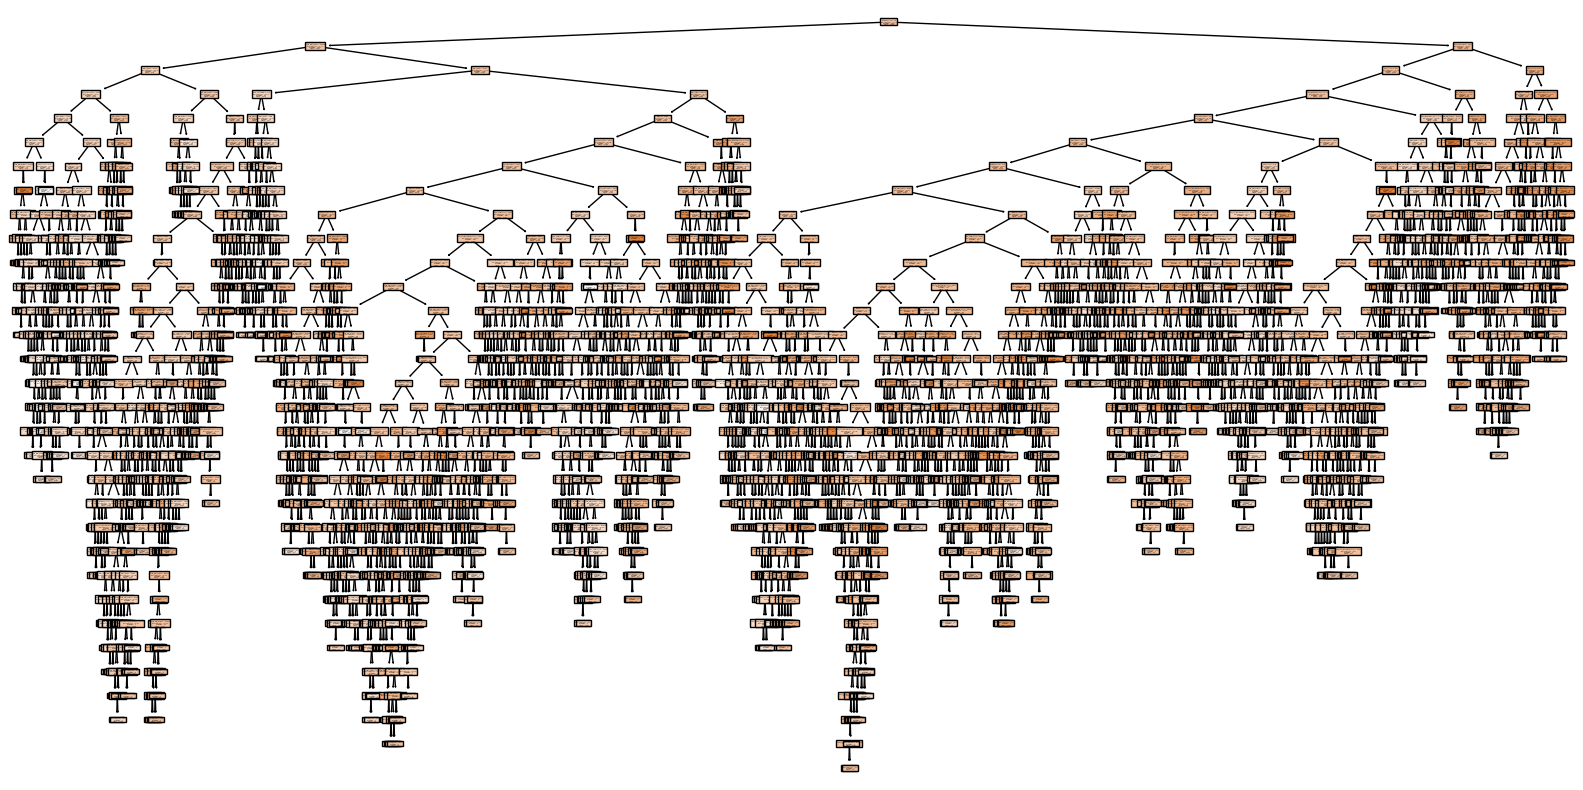

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Créer un modèle de forêt aléatoire et l'entraîner
forest_model = RandomForestRegressor(random_state=42)
forest_model.fit(X_train, Y_train)

# Sélectionner un arbre dans la forêt aléatoire
single_tree = forest_model.estimators_[0]

# Visualisation de l'arbre sélectionné
plt.figure(figsize=(20, 10))
plot_tree(single_tree, filled=True, feature_names=X.columns)
plt.show()


Decision tree

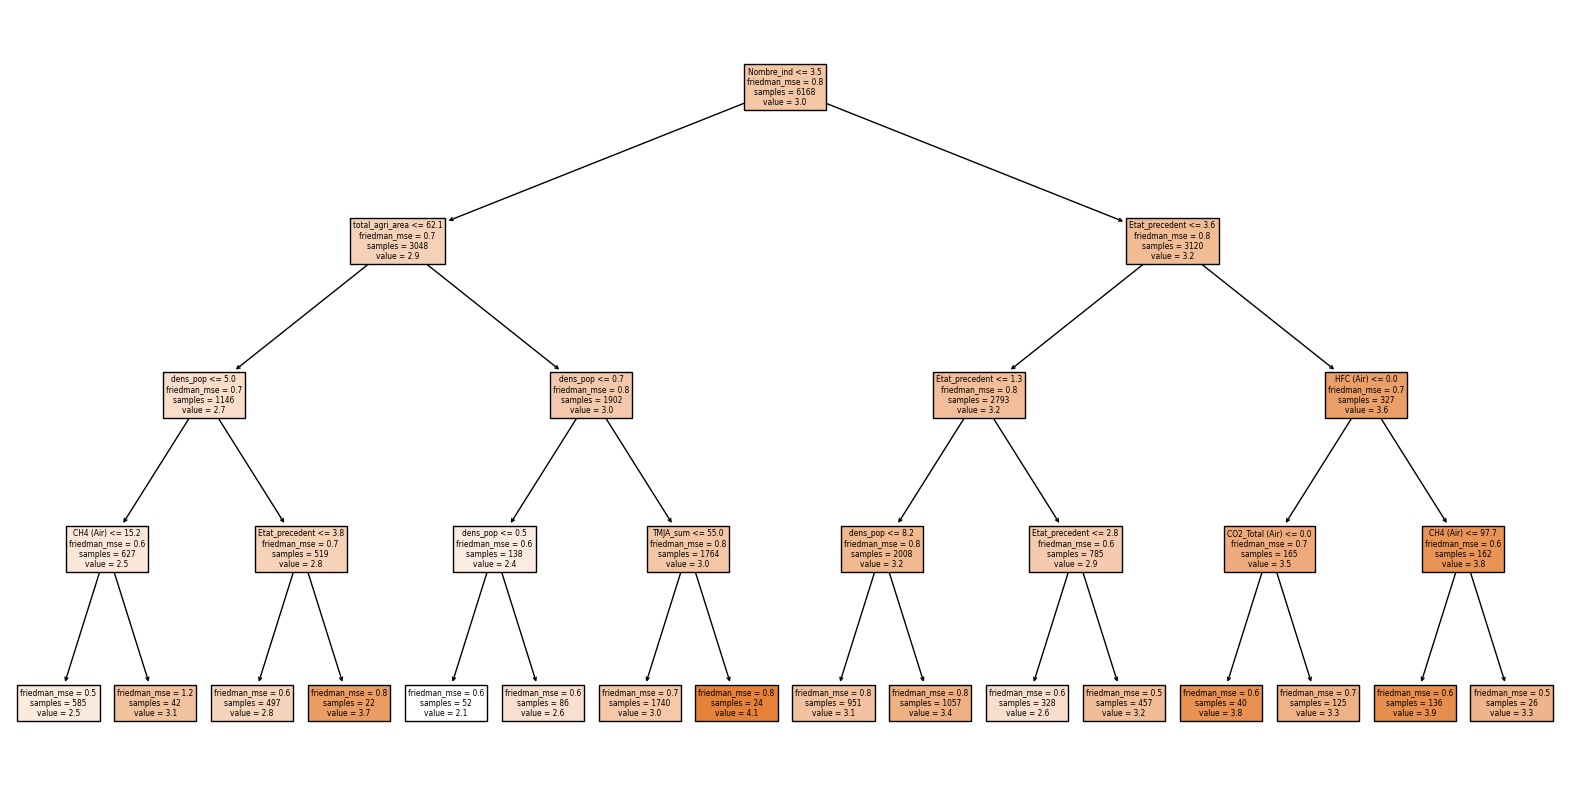

In [58]:
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(best_tree_regressor, precision=1, filled=True, label= 'all',
 feature_names=X.columns, class_names=None, rounded = False)

plt.show()

<h3 id="coeff">Visualisations des coefficients</h3>


Visualisations standardisées - comparaisons de la magnitude des coefficients


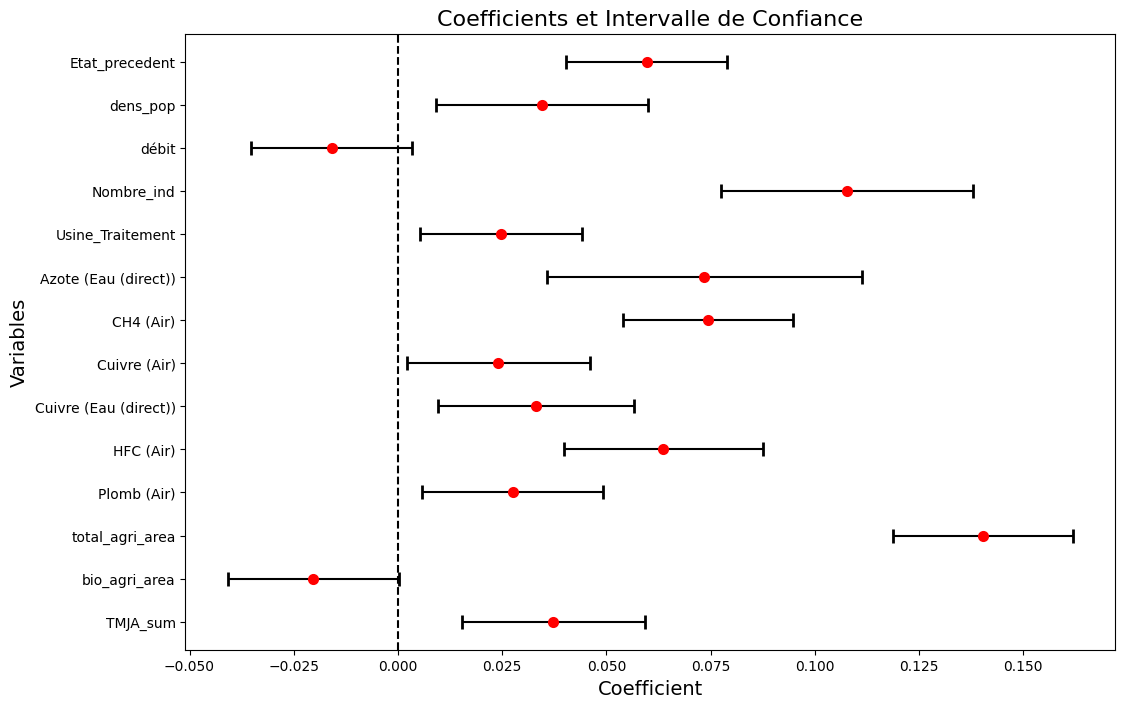

In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Suppose que `conf` est un DataFrame contenant vos coefficients et intervalles de confiance
# avec les colonnes 'Coefficient', '2.5%', '97.5%'

# Customisation des erreurs pour l'affichage
errors = conf[['Coefficient', '2.5%', '97.5%']].copy()
errors['err_neg'] = conf['Coefficient'] - conf['2.5%']
errors['err_pos'] = conf['97.5%'] - conf['Coefficient']
errors['y_position'] = np.arange(len(errors))

# Création du graphique
plt.figure(figsize=(12, 8))
plt.errorbar(errors['Coefficient'], errors['y_position'], xerr=[errors['err_neg'], errors['err_pos']], fmt='o', color='red', ecolor='black', capsize=5, elinewidth=1.5, markeredgewidth=2)

# Ajout des lignes verticales de référence
plt.axvline(x=0, color='black', linestyle='--')

# Ajout des étiquettes sur l'axe des y
plt.yticks(errors['y_position'], errors.index)

# Inversion de l'axe des y pour correspondre à votre graphique
plt.gca().invert_yaxis()

# Customisation additionnelle pour correspondre à l'image que vous avez téléchargée
plt.title('Coefficients et Intervalle de Confiance', fontsize=16)
plt.xlabel('Coefficient', fontsize=14)
plt.ylabel('Variables', fontsize=14)
#plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='blue')

# Affichage du graphique
plt.show()


Coefficients des polluants 

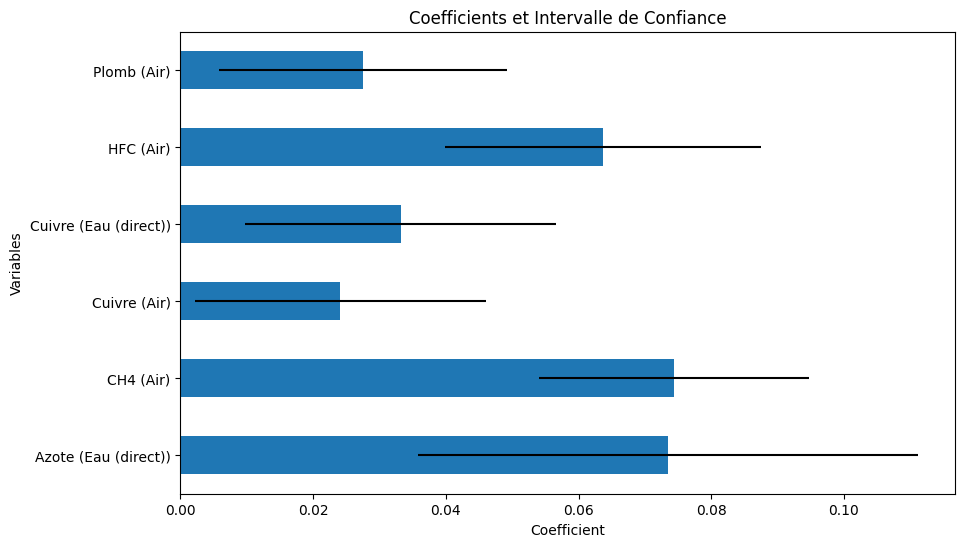

In [64]:
coefficients = model_standardized.params
conf = model_standardized.conf_int()
conf['Coef'] = coefficients
conf.columns = ['2.5%', '97.5%', 'Coefficient']

conf = conf.drop('const')  # Optionnel, retire la constante si présente
conf = conf.drop(['TMJA_sum', 'Etat_precedent', 'dens_pop', 'débit', 'Nombre_ind', 'Usine_Traitement','total_agri_area', 'bio_agri_area', 'CO2_Total (Air)', 'CO2_Non_Biomasse (Air)','CO2_Biomasse (Air)', 'Phosphore (Eau (direct))', 'Plomb (Eau (direct))'])  # Optionnel, retire la constante si présente


plt.figure(figsize=(10, 6))
conf['Coefficient'].plot(kind='barh', xerr=(conf['Coefficient'] - conf['2.5%'], conf['97.5%'] - conf['Coefficient']))
plt.title('Coefficients et Intervalle de Confiance')
plt.xlabel('Coefficient')
plt.ylabel('Variables')
plt.show()
